# ACIT5900: Master Thesis
### *Exploratory Data Analysis*

>-------------------------------------------
> *Spring 2025*

>--------------------------------------------

<a id="top"></a>
1. [**Basic Statistics**](#statistics)<br>
2. [**Visualize Content Column**](#content-visualization)<br>
3. [**Visualize Other Columns**](#others-visualization)<br>
4. [**Co-authorship Knowledge Graph**](#knowledge-graph)<br>

In [1]:
!pip install networkx matplotlib

In [2]:
# import modules needed
import string
import pandas as pd
import networkx as nx
from ast import literal_eval
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [3]:
# read data
df = pd.read_csv('df_cleaned.csv')
df.head()

,title,authors,year_published,number,volume,journal,type,content,doi,file,abstract,cleaned_content,cleaned_abstract,cleaned_authors
0,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,missing,missing,missing,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28,"—Securing and managing large, complex enterpri...",Advanced Passive Operating System Fingerprinti...,"—Securing and managing large, complex enterpri...","['Desta Haileselassie Hagos', 'Martin Løland',..."
1,Artificial intelligence in the fertility clini...,"Riegler, M A and Stensen, M H and Witczak, O a...",2021,9.0,36,Human Reproduction,article,.................................................,10.1093/humrep/deab168,doc14,": In recent years, the amount of data produced...",.................................................,": In recent years, the amount of data produced...","['M A Riegler', 'M H Stensen', 'O Witczak', 'J..."
2,EvoDynamic: A Framework for the Evolution of G...,"Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz...",2020,missing,missing,missing,inproceedings,EvoDynamic: a framework for the evolution of\n...,missing,doc10,. Dynamical systems possess a computational ca...,EvoDynamic: a framework for the evolution of g...,. Dynamical systems possess a computational ca...,"['Sidney Pontes-Filho', 'Pedro Lind', 'Anis Ya..."
3,A general representation of dynamical systems ...,Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...,2019,missing,abs/1907.01856,CoRR,article,A general representation of dynamical systems ...,missing,doc11,—Dynamical systems are capable of performing c...,A general representation of dynamical systems ...,—Dynamical systems are capable of performing c...,"['Sidney Pontes-Filho', 'Anis Yazidi', 'Jianhu..."
4,Exploring Multilingual Word Embedding Alignmen...,"Aaby, Pernille\nand Biermann, Daniel\nand Yazi...",2023,missing,missing,missing,inproceedings,"\n \n \n \nAccepted manuscript \nAaby, P., Bi...",missing,doc12,". Contextual language models, such as transfor...","Accepted manuscript Aaby, P., Biermann, D., Ya...",". Contextual language models, such as transfor...","['Pernille Aaby', 'Daniel Biermann', 'Anis Yaz..."


## <a id="statistics"></a> 1) Basic Statistics

[⬆️ Back to Top](#top)

In [4]:
# investigate basic statistics
df['text_length'] = df['cleaned_content'].apply(len)  
df['text_length'].describe() 

count        17.000000
mean      51938.470588
std       23881.024088
min       22320.000000
25%       34247.000000
50%       44360.000000
75%       68223.000000
max      109922.000000
Name: text_length, dtype: float64

## <a id="content-visualization"></a> 2) Visualize Content Column

[⬆️ Back to Top](#top)

In [5]:
# list of words to remove
stop_words = set(ENGLISH_STOP_WORDS)  

# tokenize the text and remove stop words, punctuation, and numbers
words = ' '.join(df['cleaned_content']).split()
filtered_words = [
    word for word in words 
    if word.lower() not in stop_words and word not in string.punctuation and not word.isdigit()
]

# count word frequencies
word_counts = Counter(filtered_words)

# top 20 most common words
common_words = word_counts.most_common(20)
print(common_words)

[('data', 468), ('et', 402), ('using', 339), ('learning', 323), ('used', 273), ('al.', 253), ('pp.', 245), ('network', 242), ('vol.', 235), ('model', 233), ('J.', 220), ('based', 212), ('number', 205), ('IEEE', 201), ('use', 201), ('M.', 195), ('different', 189), ('results', 188), ('AI', 186), ('S.', 183)]


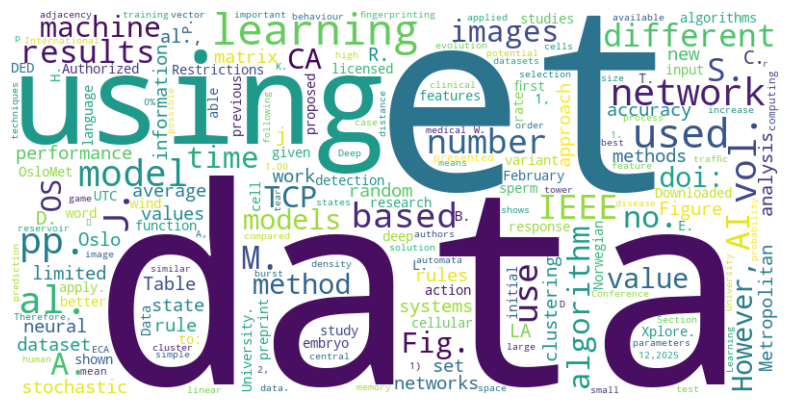

In [6]:
# create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['cleaned_content'])

# extract top 20 bigrams
bigram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(bigram_df.sum(axis=0).sort_values(ascending=False).head(20)) 


et al                      431
machine learning           141
doi 10                     133
deep learning              114
metropolitan university    105
oslo metropolitan          105
tcp variant                104
oslomet oslo                80
utc ieee                    74
use limited                 74
university downloaded       74
restrictions apply          74
authorized licensed         74
limited oslomet             74
licensed use                74
ieee xplore                 74
downloaded february         74
xplore restrictions         74
cellular automata           73
neural networks             71
dtype: int64


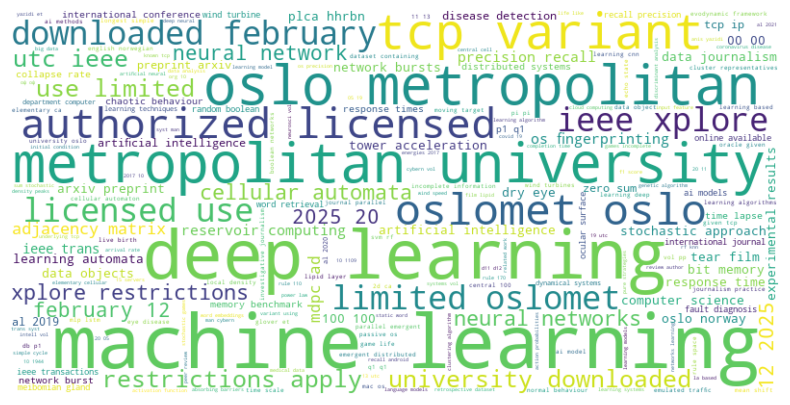

In [8]:
# words to exclude from bigram
stop_words = ['et al', '10 10', 'doi']

# extract bigrams without limiting the number of features
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['cleaned_content'])
bigram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# get all bigrams
all_bigrams = bigram_df.sum(axis=0)

# filter out the unwanted bigrams
filtered_bigrams = all_bigrams[~all_bigrams.index.str.contains('|'.join(stop_words))]

# create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_bigrams.to_dict())

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## <a id="others-visualization"></a> 3) Visualize Other Columns

[⬆️ Back to Top](#top)

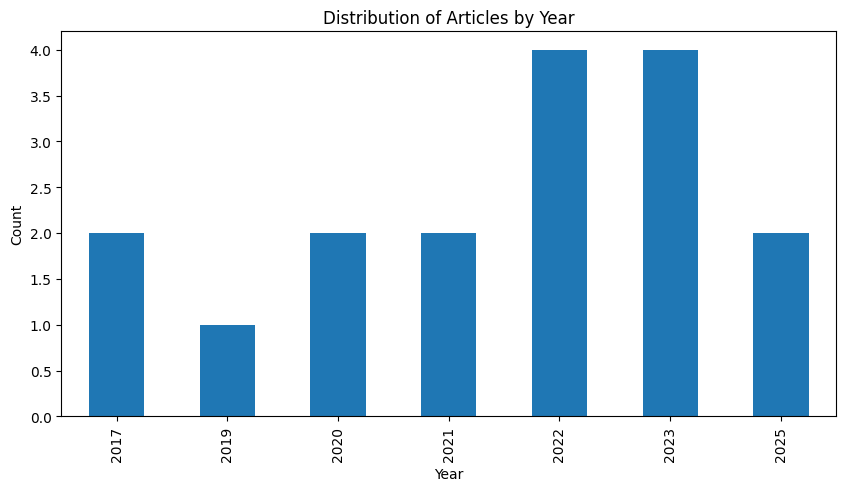

In [9]:
# amount of articles extracted for each year
df['year_published'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

## <a id="knowledge-graph"></a> 4) Co-authorship Knowledge Graph

[⬆️ Back to Top](#top)

In [10]:
df[['cleaned_authors']]

,cleaned_authors
0,"['Desta Haileselassie Hagos', 'Martin Løland',..."
1,"['M A Riegler', 'M H Stensen', 'O Witczak', 'J..."
2,"['Sidney Pontes-Filho', 'Pedro Lind', 'Anis Ya..."
3,"['Sidney Pontes-Filho', 'Anis Yazidi', 'Jianhu..."
4,"['Pernille Aaby', 'Daniel Biermann', 'Anis Yaz..."
5,"['Sidney Pontes-Filho', 'Annelene Gulden Dahl'..."
6,"['Fabrizio Palumbo', 'Adam Buji', 'Anis Yazidi..."
7,"['R. Krøvel M. Fridman', 'F. Palumbo']"
8,"['Krishna Kumar Sharma', 'Ayan Seal', 'Anis Ya..."
9,"['Tom Eivind Glover', 'Ruben Jahren', 'Frances..."


In [11]:
# convert to python list
df['cleaned_authors'] = df['cleaned_authors'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)


/var/folders/32/blww0r_s507dkfvsqxqlglzw0000gn/T/ipykernel_10323/349219432.py:35: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/celinelangeland/projects/master-thesis/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


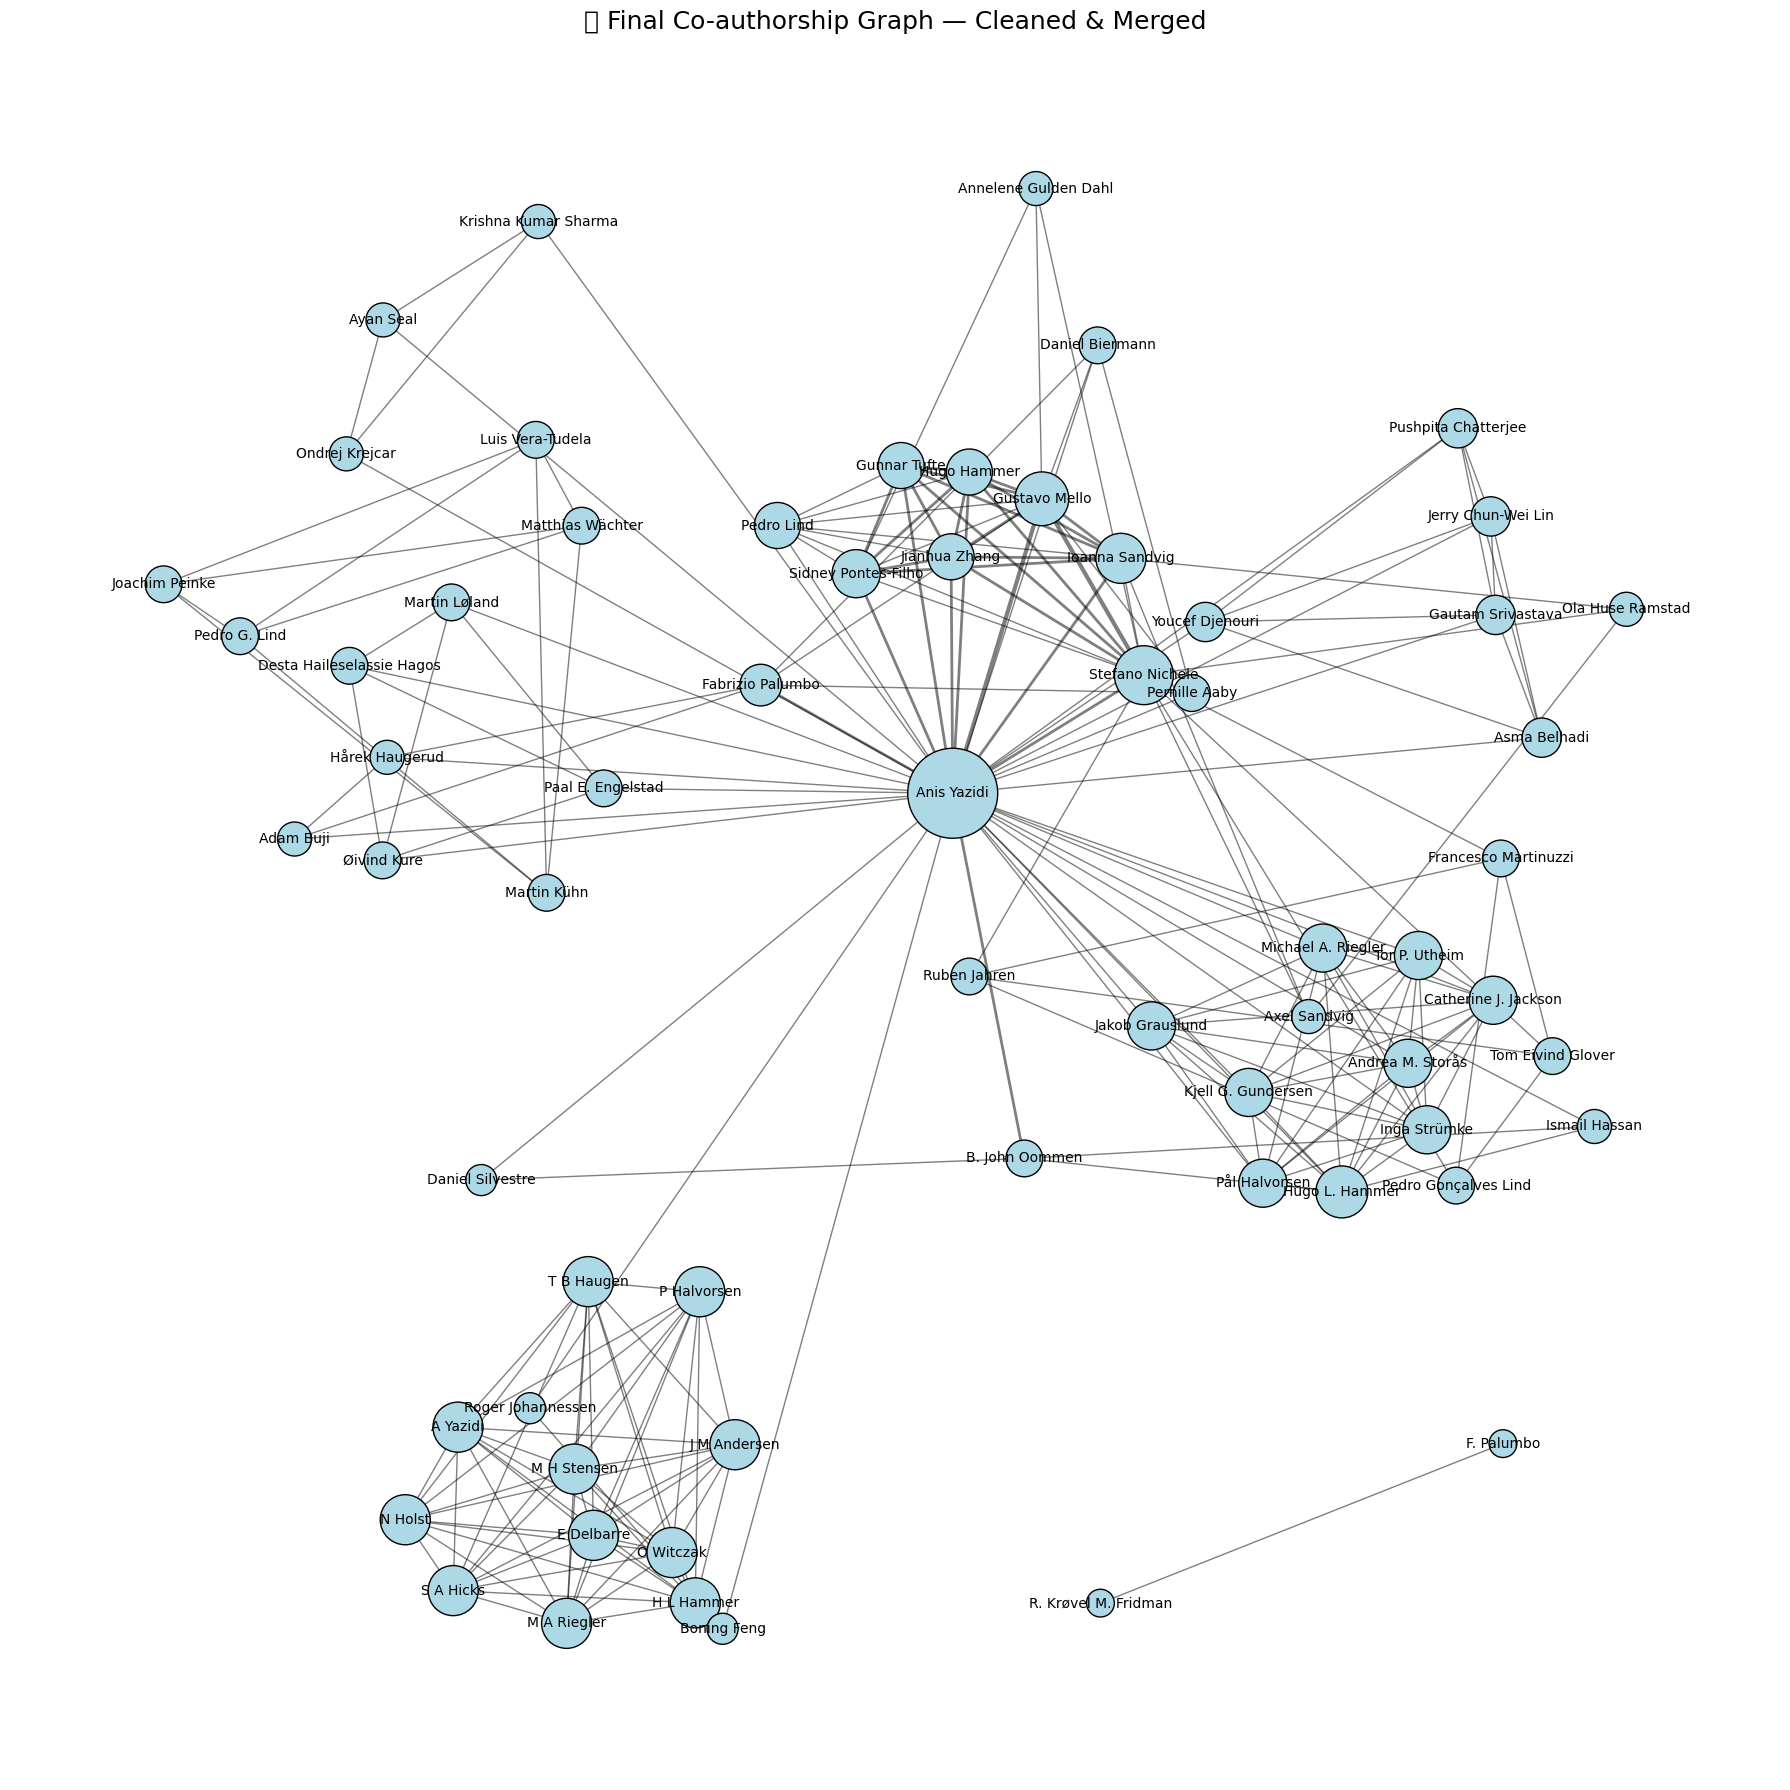

In [12]:
# build edges from co-authorship
edges = []
for authors in df['cleaned_authors']:
    unique_authors = list(set(authors))  
    edges += combinations(unique_authors, 2)

# count co-authorship frequency
edge_weights = Counter(edges)

# build graph
G = nx.Graph()
for (a1, a2), weight in edge_weights.items():
    G.add_edge(a1, a2, weight=weight)

# draw graph
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, k=0.7, seed=42)
degrees = dict(G.degree())

nx.draw_networkx_nodes(
    G, pos,
    node_size=[300 + degrees[n] * 100 for n in G.nodes],
    node_color='lightblue',
    edgecolors='black'
)
nx.draw_networkx_edges(
    G, pos,
    width=[G[u][v]['weight'] for u, v in G.edges],
    alpha=0.5
)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("🧹 Final Co-authorship Graph — Cleaned & Merged", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()